Yesterday, Richard McElreath had a lovely [blog post](https://elevanth.org/blog/2023/07/17/none-of-the-above/) on why the Bayes factor isn't the cure to what ails us. No p-values or No confidence intervals, either. No metric of any kind can replace the need for clear model-first thinking as the justification for scientific claims. A common reaction to Richard's post is to ask the obvious question, "if none of the above, then what?" The question underscores just how difficult it is to imagine another kind of science. 

A casual aquaintance with the p-value wars of the last decade leaves one with the impression that we are searching for some metric which we can stamp on a scientific paper to let everyone know we did a good job. If not the p-value, then surely something else: a cross-validation score, a low AIC score, a big effect size, a big likelihood ratio. Maybe a good paper is the one that has `(N = 1,000,000,000)` in the abstract! There is a pretense to these conversations: if we just tweak our metric correctly, we can also tweak the publication pipeline and stabilize science. Bayesians in Richard's camp are asking a provocative question - what if the pretense is wrong? How could we justify a scientific claim in the absence of any of the metrics? 

It turns out the answer is not mysticism. A humble cycle of model-building and fitting is usually all we need. The metrics listed above have their proper place. It's just that they are rarely what is called for. A model-first approach makes it obvious when they are useful and how to deploy them. The philosophical arguments for this approach have been spelled out before [@gelman2013a]. But it is still quite hard to imagine what it looks like from these abstract methodological descriptions. The rest of this post provides a compact and easy to follow example of the full model-first workflow. The promise is that, by the end, we won't have needed a metric to assess our model and you won't miss them. We'll learn something important without ever reaching for them.

We are going to study a model of technological innovation. The central claim is that big populations innovate more than small populations. We'll build up the model from basic intuitions and evaluate it against a historical dataset of island societies in Oceania. It will feel a bit too easy and that's the point. Once we carefully model our problem, there is no need to argue about p-values, bayes factors, confidence intervals or the like.

# Start from a simple mechanistic model

A scientific project starts from a theoretical model. The theoretical model represents some general causal mechanism that might be useful in explaining why the world is the way it is. The theoretical model I'll ilustrate is one developed in [@henrich2004]. The general intuition captured by the model is that larger populations have a better infrastructure to sustain innovations that accumulate over time. If a large community of people are all working on a technical problem, breakthroughs will be discovered regularly and can be disseminated to the rest of the population. However, in a small community, the quality of technical expertise can degrade over time. People forget stuff. People don't usually achieve quite the level of expertise as their teacher. Henrich envisions the rate of innovation as a balancing act between the pace of major breakthroughs and difficulty of accurately transmitting knowledge across generations.

We'll grow and validate those intuitions with a mechanistic mathematical model. Jumping right to the algebra could be tough. Easier to tell an intermediate, fairly detailed story about the mechanisms at an individual level. Imagine 100 people live in a community. Every person has a skill level represented by a continuous variable. Suppose as people's skill level advances, they can produce ever straighter arrows or more complex computer programs[^1].

[^1]: For many technologies, there will not be some continuous improvement that can be equated directly with a skill level. Instead, there is some further function that maps skillfulness onto discrete stages of improvement in a gadget or even the variety of gadgets a person can produce. Henrich sets this complexity aside to illustrate a general relationship that should hold approximately in the complex case and we'll do the same I think this is a pretty big simplification. Simplifications like this serve as an opportunity for future work, fleshing out the theory and seeing what is plausible in light of empirical evidence. To be fair, people have challenged Henrich on this one [@vaesen2016].

Everybody wants to produce the straightest arrow they can or the most complex program. They seek out the best teachers with the most impressive skill set. The skill level of the best individual is denoted by $z$. People make two kinds of errors during learning: 

- First, the skill might be hard to learn. Observing the best person gives you a clue about what skillful performance looks like. But a clue is not usually enough. These sorts of errors arise from the inherent difficult of a skill and are represented by the parameter $a$. 

- Second, there might be individual-level variability in how well folks can copy skills. Some people might have greater perception, memory, or intelligence and achieve a skillfulness pretty close to the best. Others do much worse. A few people might even innovate on the best design and achieve a higher level of skillfulness. Individual-level variability is represented by parameter $b$. 

To combine these three processes (imitation, inherent difficulty, variability), people sample their new skill level from a probability distribution with a mean value set at $z - a$ and the spread of the distribution is given by $b$. To put it less mathematically, people aim to learn from the best, fail to imitate them exactly, fall back to toward the average and then disperse from there. Many probability distributions work fine for achieving the same results. Henrich selected the right-skewed Gumbel distribution depicted in @fig-skill-distribution. Here I assume the best individual has skillfulness $z = 15$, while $a = 5$ and $b = 1$. The Gumbel distribution allows individuals to occassionally discover large improvements on the skill when they draw from the region greater than 15, marked by red on the plot.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
from scipy import stats
from matplotlib import cm

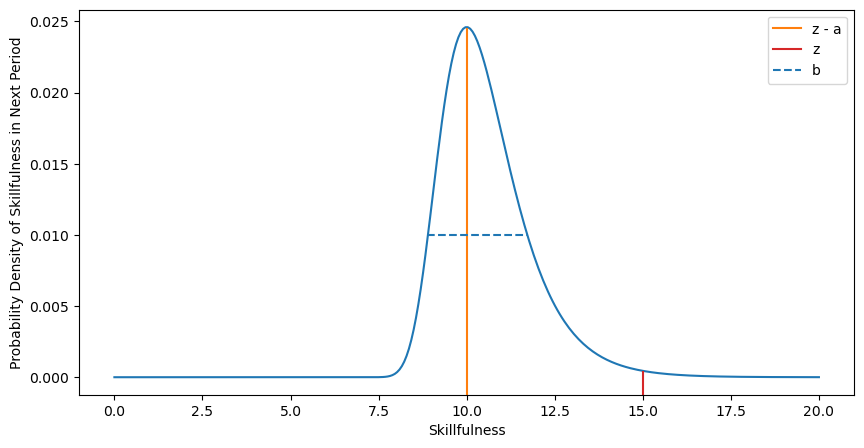

In [4]:
#| label: fig-skill-distribution
#| fig-cap: "Illustration of learning mechanism in the treadmill model"

x = np.linspace(0,20,300)
y = stats.gumbel_r(10,1).pdf(x)
y = y / sum(y)

plt.figure(figsize=(10,5))
plt.plot(x,y,color="tab:blue")
plt.axvline(10,ymin=0,ymax=.95,label="z - a",color="tab:orange")
plt.axvline(15,ymin=0,ymax=.06,label="z",color="tab:red")
plt.plot([8.88,11.7],[.01,.01],'--',label="b",color="tab:blue")
plt.xlabel("Skillfulness")
plt.ylabel("Probability Density of Skillfulness in Next Period")
plt.legend();

Over many time steps, people repeat the learning process, gettting better or worse each time. Population size turns out to matter because it increases the odds some lucky individual will exceed the most skillful individual in the current generation. In the next generation, this exceptional student will become the teacher. When this happens consistently, it can pull the average skill level up over time. However, if people rarely exceed the best, then inherent difficultly in transmission will pull the average skill level down. Henrich shows that the expected change in skillfulness from one time step to the next is:

$$ z' = -a + b*(\gamma + \ln(n)) $$

where $a$ and $b$ are as defined above, $\gamma$ is the Euler-Gamma constant (0.5772...) and $\ln(n)$ is the natural log of the population size. We'll call this *treadmill model* of innovation. If you don't keep walking forward, you're sliding backward.

Simulations depicted in @fig-four-societies show four different population sizes working on learning problems with the same $a$ and $b$ parameters and their expected level of skillfullness. They repeat the learning process for 30 iterations. Two of them experience cumulative evolution, one of them is in a steady state and one experiences skill decay.

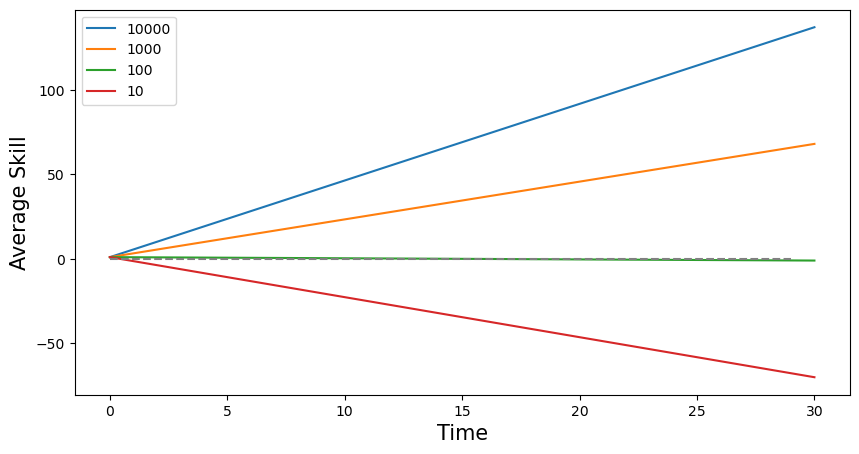

In [5]:
#| label: fig-four-societies
#| fig-cap: "Cumulative social learning is sensitive to population size"


N = [10000,1000,100,10]

iterations = 30
a = 5.25
b = 1

plt.figure(figsize=(10,5))

for n in N:

    z_bar = 1
    z_bar_record = [z_bar]

    for j in range(iterations):
        z_bar = -a + b*(np.euler_gamma + np.log(n)) + z_bar
        z_bar_record.append(z_bar)

    plt.plot(z_bar_record,label=n)
    
plt.xlabel('Time',fontsize=15)
plt.ylabel('Average Skill',fontsize=15)
plt.plot([0]*iterations,'--',color='grey')
plt.legend();

# Build your statistical model out of the mechanistic model

Now we have the theoretical claim that big populations should have more advanced technology than small populations. We built it up from mechanistic thinking about individuals. But is our big theoretical claim true? At this point, the common temptation is to turn to a linear regression where population size is the independent variable and some measure of technological innovation is the dependent variable. Resist the temptation. Don't do this. The linear regression invites us back to the world of p-values, confidence intervals and bayes factors. Paul Smaldino describes the problem with a bit of colour:

> Consider that calculating inferential statistics involves constructing a model of your data-generating process, usually with strong simplifying assumptions about the distributions of parameter values. You don’t need to do this, because you already have a better model of your data-generating process: it’s your actual model. There’s no reason to model your model with a shittier model. [@smaldino2020a]

We just built a model that helps us generate predictions about tools from information about population sizes. It has two parameters. It does the same job as the linear regression we are after. But better. It has the precise structure of our theory. The parameters of this model can be interpreted in the very terms of our scientific theory, in terms of inherent difficult and individual variability. When people describe their linear models in statistically precise language, they are forced to say things like "a one-magnitude increase in population increases the level of technology by 0.5 standard deviations." Stop it. What are you talking about?

About 10 years ago, some scientists studying the treadmill model actually did fit a linear regression to a dataset with 10 island societies in Oceania that included a measure of technology and population size[@kline2010]. Ethnographic accounts written around the time Europeans first contacted Oceanic societies contain descriptions of an island's approximate population size and their toolkits. They coded the ethnographic accounts to develop an index of the number of distinct tools[^2]. We are going to borrow their data but ditch the regression. 

Being inspired by a mechanistic model, as Kline and Boyd were, is better than nothing. It is certainly better than the often theory-free style in some parts of social science that searches out robust correlations by running dozens of statistical analyses. But this loose connection between the linear regression and the mechanistic model is the "metaphorical relationship" between theory, model, and evidence that McElreath cautions against. Relying on a secondary model to perform the analysis casts a shadow over our study. We need there to be some translation between the parameters of the linear regression and the mechanistic model via some underspecified and vague function. Unspecified functions obscure logical errors and make constructive criticism more difficult. 

In our case, we should be skeptical that a linear regression closely maps onto our treadmill model. The treadmill model expresses a non-linear relationship between *time* and population size. Societies need time to iteratively develop their toolkits in order to take advantage of their population size. We could explore multiple predictor regressions or regressions with interaction effects. [If we are clever, I'm sure we could get a regression that does something close](https://www.youtube.com/watch?v=Doaod09YitA). But ultimately we are ignoring our best option. Smaldino's suggestion is to cut out the middleman and just fit the mechanistic model. 

[^2]: If you are wondering whether we can reliably measure the complexity of a tool based on ethnographic reports written during the period of European colonization, you are not alone [@jerven2011]. But the part of this case study that is interesting for our purposes does not concern data quality. I will assume these measures are appropriate for the sake of the larger argument.

# Fit your model to your data

What would it look like to fit our mechanistic model? We'll need a few ingredients.

First, a differential equation solver. Henrich gives us the model in the form of differential equation. We know how to go from the current time step to the next time step by repeatedly applying the equation. So it is a different kind of problem than fitting a linear regression. Fortunately, the [software](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html) for this sort of problem has gotten quite good in the last few years. We can solve the differential equation recursively for $t$ periods, where $t$ is the length of time that people have lived on the island until the society was observed by Europeans. A body of scholarly work aims to provide a precise settlment chronology for the islands of Oceania. Melansian islands settlement chronology is taken from @matisoo-smith2015. The settlement date from Tonga comes from @burley2012 and Hawaii is taken from @wilmshurst2011. Once we've iterated the recursion a sufficient number of times, we get a prediction for how many tools a society should have[^3].

[^3]: We don't have to use a differential equation solver. We could just integrate the differential equation to get an analytical expression for the number of tools as function of $a,b,n,t$. It would be faster and more accurate too. But I had already worked out the differential equation approach by the time I realized it was an easy integration problem so here's what we get. Still nice to know the fitting differential equations ain't too hard.

Second, a error distribution. Each prediction will come with a certain amount of error - the observed level of technology might departed from the predicted level due to any number of small, unosberved causes. The error can be modeled with a probability distribution that takes the prediction as a mean and then spreads probability around that point. Given that the data is discrete and non-negative, a Poisson distribution is an appropriate choice to model the error [@mcelreath2020, ch 12].

Third, priors. Each island has a unique population size and length of the development period so we end up with a unique differential equation for each island. The equations share the parameters $a$ and $b$, which provide a course-grained quantification of the difficulty of technological development in the region. While $n$ and $t$ are treated as knowns, the difficulty parameters must be estimated. The prior over $a$ was a Gamma with a mu of 15 and a sigma of 5. The prior over $b$ was a Gamma with a mu of 1 and sigma of 2. These priors were chosen based on prior predictive simulations. I tuned the prior distributions to predict that each society would roughly have been 1000 and -1000 skillfulness with the bulk of the prior predictive density around 0. This is desirable because it discounts the implausible scenarios where societies have massive toolkits. However, it does not bias the analysis in favour of the demographic theory of technology because it is still very possible for population size to barely help innovation.

Selecting priors is something that makes people nervous. Who gives me the right to just invent information about the difficulty of learning a skill in societies I've never been to? I'm a guy who works on computer all day devising models. I haven't even hard a book about Tonga. In our case, building priors is the same thing as building the mechanisms in our theoretical model. I have to make decisions about what sorts of human behaviour is plausible. I really don't know that much. But I don't think my treadmill mechanism should enable explosive technological growth to the point where some societies have as many unique tool experts as they have people. I feel confident building a constraint in against that without reading a book on Polynesian technology. But if you read the book, you could devise better priors and smarter analysis.

At this point, we have everything we need. I fit the model behind the scenes. Then I sampled predictions from our newly fit model.

In [ ]:
# set up the Ordinary Differential Equation (ODE) for each island.

from pymc.ode import DifferentialEquation

def henrich_derivative(y,t,p):
    
    a,b,n = p[0],p[1],p[2]
    
    return -a + b*(np.euler_gamma + np.log(n))  + 0*y[0]

times = dk.initial_settlement.values
pop = dk.population.values
tools = dk.total_tools.values

ode_malekula = DifferentialEquation(func=henrich_derivative, times=times[0], n_states=1, n_theta=3)
ode_tikopia = DifferentialEquation(func=henrich_derivative, times=times[1], n_states=1, n_theta=3)
ode_santa_cruz = DifferentialEquation(func=henrich_derivative, times=times[2], n_states=1, n_theta=3)
ode_yap = DifferentialEquation(func=henrich_derivative, times=times[3], n_states=1, n_theta=3)
ode_lau_fiji = DifferentialEquation(func=henrich_derivative, times=times[4], n_states=1, n_theta=3)
ode_trobriand = DifferentialEquation(func=henrich_derivative, times=times[5], n_states=1, n_theta=3)
ode_chuuk = DifferentialEquation(func=henrich_derivative, times=times[6], n_states=1, n_theta=3)
ode_manus = DifferentialEquation(func=henrich_derivative, times=times[7], n_states=1, n_theta=3)
ode_tonga = DifferentialEquation(func=henrich_derivative, times=times[8], n_states=1, n_theta=3)
ode_hawaii = DifferentialEquation(func=henrich_derivative, times=times[9], n_states=1, n_theta=3)

In [ ]:
# configure model

with pm.Model() as m0:
    # Specify prior distributions for some of our model parameters
    a = pm.Gamma('a',mu=15,sigma=5)
    b = pm.Gamma('b',mu=1,sigma=2)

    # If we know one of the parameter values, we can simply pass the value.
    s1 = ode_malekula(y0=[0], theta=[a,b,pop[0]])
    s2 = ode_tikopia(y0=[0], theta=[a,b,pop[1]])
    s3 = ode_santa_cruz(y0=[0], theta=[a,b,pop[2]])
    s4 = ode_yap(y0=[0], theta=[a,b,pop[3]])
    s5 = ode_lau_fiji(y0=[0], theta=[a,b,pop[4]])
    s6 = ode_trobriand(y0=[0], theta=[a,b,pop[5]])
    s7 = ode_chuuk(y0=[0], theta=[a,b,pop[6]])
    s8 = ode_manus(y0=[0], theta=[a,b,pop[7]])
    s9 = ode_tonga(y0=[0], theta=[a,b,pop[8]])
    s10 = ode_hawaii(y0=[0], theta=[a,b,pop[9]])
    
    mu = pt.as_tensor([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10])

    Y = pm.Poisson("Y", mu=mu[:,0,0],observed=tools)

In [ ]:
# prior predictive check
# you should see most the mass clustered at zero, a bit asymmetrically skewed positive and
# a few outliers with giant amounts of tools

pp = pm.draw(mu,draws=100)
for val in pp[:,:,-1,-1]:
    plt.plot(val,'o',alpha=0.3)

In [ ]:
# fit the model

with m0:
    t = pm.sample(tune=1000,draws=3000,target_accept=0.95)

In [ ]:
# resample predictions from the fitted model

post_pred_m0 = pm.sample_posterior_predictive(model=m0,trace=t)

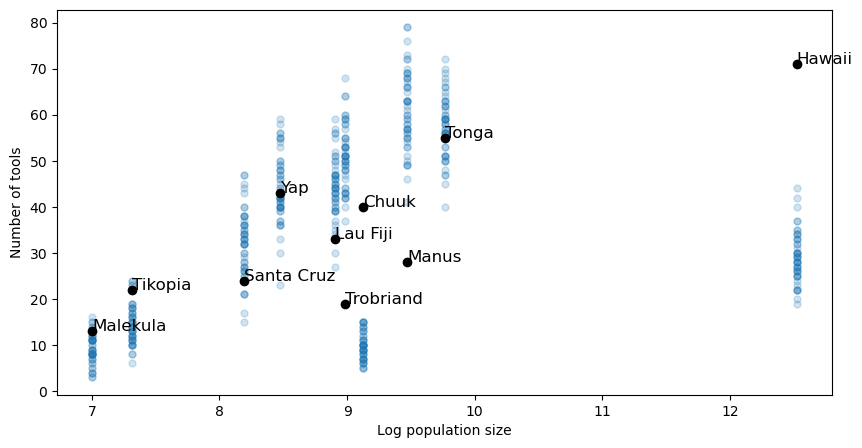

In [9]:
#| label: fig-bespoke-predictions-1
#| fig-cap: "Model-based predictions by population size"

try:
    dk = pd.read_csv("Kline",sep=";")
except FileNotFoundError:
    dk = pd.read_csv("https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/Kline",sep=";")

dk["contact_id"] = [0,0,0,1,1,1,1,0,1,0]
dk['log_pop'] = np.log(dk['population'])
dk['standardized_log_pop'] = (dk['log_pop'] - dk['log_pop'].mean()) / dk['log_pop'].std() 
dk['log_tools'] = np.log(dk['total_tools'])
times = [[3000],[3000],[3000],[3500],[3000],[3350],[600],[3350],[2845],[800]]
times = [[i[0] / 100] for i in times]
dk['initial_settlement'] = times

predictions = post_pred_m0.posterior_predictive['Y'].values.reshape((12000,10))
label_id = dk.culture.values

fig, ax = plt.subplots(figsize=(10,5))

for index in range(len(label_id)):
    ax.text(np.log(dk.population.values)[index], dk.total_tools.values[index], label_id[index], size=12)

for k in range(50):
    i = np.random.randint(low=0,high=4000)
    plt.plot(np.log(dk.population.values),predictions[i],'o',alpha=0.2,color="tab:blue",markersize=5)
    
plt.plot(np.log(dk.population.values),dk.total_tools.values,'o',color="black")
plt.xlabel("Log population size")
plt.ylabel("Number of tools");

# Criticize your model

The results illustrate the major strengths of our modeling strategy. @fig-bespoke-predictions-1 depicts 100 predictions generated from the fitted model. The parameters are estimated with uncertainty so the predictions also come with uncertainity. Each prediction is a transparent blue circle. Regions with darker colours are places where the predictions overlap, suggesting that model is more certain that true value should fall in that region. @fig-bespoke-predictions-1 makes clear that the model does a fairly good job of explaining 6 of the societies. However, the model struggles to explain why Hawaii and Chuuk have as many tools as they do. Similarly, the model struggles to explain why Manus and Trobriand have so few tools, given their moderate population sizes.

Normally, at this point in a scientific paper, we'd start reporting our favoured p-value / confidence interval / Bayes factor / whatever. This would, somehow, tell us whether our treadmill model is better than some null model. Maybe in this case the null model simply assumes there is no correlation between population size and technological complexity. It would probably turn out that our treadmill model performs much better than the null model or the null model would be a poor fit to the data. But a boxing match against the null model isn't worth watching. At best, we learn something fairly minor. At worst, it encourages us to claim success, submit to the journal, and stop asking further questions that could revise and improve our theoretical model.

Lingering on these results for a minute tells us a story. Hawaii and Chuuk are very young islands compared to the rest. Estimates suggest Hawaii was settled by its indigenous population around 800 years ago. Chuuk, 600. The model gives us small predicted values because there hasn't been enough time to develop a large toolkit through population-size driven innovation alone. If we pushed the parameters around to enable fast growth for these two islands, we'd overshoot the other societies. 

We know that all models are wrong and only some are useful. The hard question is to figure out which ways of being wrong matter and which ones don't. The treadmill model is simple. We are clearly ignoring other factors that might contribute to innovation. The results tell that whatever is missing clearly *matters* for explaining the four anomolous societies. 

I'll put forward one plausible suggestion. Islands are not settled by people who arrive empty handed. They are settled by people who have already benefited from generations of innovation. The folks who settled Hawaii likely came from Tonga, a very successful, advanced, and influential society in Oceania. If we could create a more dynamic model of the initial level of skillfulness, it might go a long way. We could construct a cultural phylogeny based on which societies settled which other ones. Then we'd set the initial level of skillfulness to be equal to the settling society's skillfulness at the time they arrived. Or simply, Hawaii should start out with all the tools Tonga had in 1200 AD. This interdependence among intercepts would push the growth rate down (you don't need to innovate as fast to explain the data if everyone starts with more) and likely improve our fit to Manus and Trobriand too.

I'll end the blog post before I try to build that model. The point is to illustrate a way of thinking about models and inference rather than settle the fate of the treadmill model. The point is this: the model could be improved in a virtuos cycle with the data analysis. Kind like, you know, as if the scientific method was real. But appreciate that all the reasoning I sketched above is qualitative and mechanistic. I see what my model can and cannot explain. I think up reasons why the model failed and see if there are plausible mechanisms that could be added to improve performance. It is not hypothesizing after the facts are known (HARKing). It's learning.

I'll just close with this long quote from I like from a philosopher of science who did case study work on nuclear physics. If the Bayes factor was the solution, you'd think a science as mathematically sophisticated as physics would be deploying them with vigour. Instead the picture is stranger and yet all the more familiar:

> One then visually compares the theoretical curves with the data points and judges whether the fit is "extraordinarily good," "very good," "good," "reasonably good," "lacking in agreement," "seriously lacking in agreement," and so on. ... This seems more like wine tasting than hard science! What about "goodness of fit" tests used by social scientists? Nuclear physicists rarely use them to judge goodness of fit. ... The best explanation of this situation I have encountered was told to me by an experimentalist. Good experiments, he said, have a margin of error of around 2 percent. But hardly any model in nuclear physics comes within 20 percent of the data. All data in the field would therefore yield very large values for any standard measure of fit, and comparisons would not be very meaningful. "More kinds of data can be assimilated by the eye and the brain in the form of a graph," he said, "than can be captured with $\chi^{2}$." [@giere1988]